First, lets create our Sagemaker session and role, and create a S3 prefix to use for the notebook example.

In [1]:
# S3 prefix
prefix = 'ems_call_volume'

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

Couldn't call 'get_role' to get Role ARN from role name tyler.c.buffington@utexas.edu to get Role path.


ValueError: The current AWS identity is not a role: arn:aws:iam::445861113736:user/tyler.c.buffington@utexas.edu, therefore it cannot be used as a SageMaker execution role

In [8]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl import Q
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import datetime
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import Holiday
from dateutil.relativedelta import SU
from dateutil.relativedelta import TH
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
plt.style.use('ggplot')

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import pandas as pd

# S3 prefix
prefix = 'ems_call_volume'
# session = boto3.session.Session(region_name='us-east-2')
# sagemaker_session = sagemaker.LocalSession(boto_session=session)
sagemaker_session = sagemaker.LocalSession()

# Get a SageMaker-compatible role used by this Notebook Instance.
# role = 'arn:aws:iam::467626235021:role/service-role/AmazonSageMaker-ExecutionRole-20190830T140378'
role = 'arn:aws:iam::445861113736:role/service-role/AmazonSageMaker-ExecutionRole-20190903T114521'

## Upload the data for training <a class="anchor" id="upload_data"></a>

I performed the following query to get the data. Right now, I'm just saving the dataframe as shown below.

In [71]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl import Q
import json
#Generating the dataframe from NFORS
es = Elasticsearch()
s = Search(using=es,index='*-fire-incident-*')
s = s.source(['description.event_opened',
                     'description.day_of_week',
                    'NFPA.type',
                     'fire_department.firecares_id'])



q = Q("match",fire_department__firecares_id =  '79592') | Q("match",fire_department__firecares_id =  '93345')
results = s.query(q)

#Performing the query and converting to pandas dataframe
df = pd.DataFrame((d.to_dict() for d in tqdm_notebook(results.scan())))
json_struct = json.loads(df.to_json(orient="records"))

df = pd.io.json.json_normalize(json_struct)

#Converting date
df['date'] = df['description.event_opened'].apply(lambda x: x[:10])
df['month'] = df.apply(lambda x: x['date'][5:7], axis=1)
df['hour'] = df['description.event_opened'].apply(lambda x: x[11:13])


#Converting df dates to datetime objects
df['date'] = df.apply(lambda x: datetime.datetime.strptime(x['date'],'%Y-%m-%d'),axis=1)
# df['date'] = df.apply(lambda x: datetime.datetime.strptime(x['date'],'%Y-%m-%d'),axis=1)

#Renaming columns for convenience
new_col = list(df.columns)
for i,column in enumerate(df.columns):
    new_col[i] = column.replace('weather.currently.','').replace('weather.daily.','')
df.columns = new_col

df.to_pickle('query_results')

In [72]:
#Getting the list of all departments in the dataframe
fdid_list = df['fire_department.firecares_id'].unique()


In [117]:
feature_list = ['fire_department.firecares_id_79592',
       'fire_department.firecares_id_93345', 'description.day_of_week_Friday',
       'description.day_of_week_Monday', 'description.day_of_week_Saturday',
       'description.day_of_week_Sunday', 'description.day_of_week_Thursday',
       'description.day_of_week_Tuesday', 'description.day_of_week_Wednesday',
       'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05',
       'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']  

In [232]:
hourly = df[['fire_department.firecares_id', 'date','description.day_of_week', 'hour', 'NFPA.type']].groupby(['fire_department.firecares_id', 'date','description.day_of_week', 'hour', 'NFPA.type']).aggregate(len).reset_index()
hourly = hourly.rename(columns={0: 'calls'})

#Determine the mean of each department by hour
means = hourly[['fire_department.firecares_id','calls']].groupby('fire_department.firecares_id').aggregate(np.mean).reset_index()
means = means.rename(columns={'calls':'mean_calls'})
hourly = hourly.merge(means, on='fire_department.firecares_id')
hourly['norm_calls'] = hourly['calls']/hourly['mean_calls']

hourly = hourly.sample(1000)

In [259]:
jsondata = {}
jsondata['model_name'] = 'calls_by_hour'
jsondata['model_version'] = 1.0
jsondata['prediction_data'] = hourly.drop('date',axis=1).to_dict(orient='records')

with open('test', 'w') as outfile:
    json.dump(jsondata, outfile)

In [271]:
with open('test','r') as file:
    data = file.read().replace('\n', '')

In [274]:
data = json.loads(data)
features = pd.io.json.json_normalize(data['prediction_data'])

In [276]:
hourly

,fire_department.firecares_id,date,description.day_of_week,hour,NFPA.type,calls,mean_calls,norm_calls
52994,93345,2017-09-14,Thursday,20,FIRE,5,6.867606,0.728056
4734,79592,2015-11-27,Friday,20,EMS,4,5.447560,0.734274
80223,93345,2019-08-01,Thursday,12,EMS,6,6.867606,0.873667
55218,93345,2017-11-09,Thursday,14,EMS,7,6.867606,1.019278
24515,79592,2018-02-20,Tuesday,21,EMS,2,5.447560,0.367137
...,...,...,...,...,...,...,...,...
3431,79592,2015-10-02,Friday,15,EMS,26,5.447560,4.772779
3963,79592,2015-10-24,Saturday,22,EMS,3,5.447560,0.550705
63347,93345,2018-06-01,Friday,16,FIRE,7,6.867606,1.019278
7888,79592,2016-04-03,Sunday,19,EMS,2,5.447560,0.367137


In [248]:
help(json.dump)

Help on function dump in module json:

dump(obj, fp, *, skipkeys=False, ensure_ascii=True, check_circular=True, allow_nan=True, cls=None, indent=None, separators=None, default=None, sort_keys=False, **kw)
    Serialize ``obj`` as a JSON formatted stream to ``fp`` (a
    ``.write()``-supporting file-like object).
    
    If ``skipkeys`` is true then ``dict`` keys that are not basic types
    (``str``, ``int``, ``float``, ``bool``, ``None``) will be skipped
    instead of raising a ``TypeError``.
    
    If ``ensure_ascii`` is false, then the strings written to ``fp`` can
    contain non-ASCII characters if they appear in strings contained in
    ``obj``. Otherwise, all such characters are escaped in JSON strings.
    
    If ``check_circular`` is false, then the circular reference check
    for container types will be skipped and a circular reference will
    result in an ``OverflowError`` (or worse).
    
    If ``allow_nan`` is false, then it will be a ``ValueError`` to
    serializ

In [247]:
hourly.to_json( orient='records')

'[{"fire_department.firecares_id":"93345","date":1505347200000,"description.day_of_week":"Thursday","hour":"20","NFPA.type":"FIRE","calls":5,"mean_calls":6.8676058219,"norm_calls":0.7280557635},{"fire_department.firecares_id":"79592","date":1448582400000,"description.day_of_week":"Friday","hour":"20","NFPA.type":"EMS","calls":4,"mean_calls":5.4475602499,"norm_calls":0.7342736595},{"fire_department.firecares_id":"93345","date":1564617600000,"description.day_of_week":"Thursday","hour":"12","NFPA.type":"EMS","calls":6,"mean_calls":6.8676058219,"norm_calls":0.8736669162},{"fire_department.firecares_id":"93345","date":1510185600000,"description.day_of_week":"Thursday","hour":"14","NFPA.type":"EMS","calls":7,"mean_calls":6.8676058219,"norm_calls":1.0192780689},{"fire_department.firecares_id":"79592","date":1519084800000,"description.day_of_week":"Tuesday","hour":"21","NFPA.type":"EMS","calls":2,"mean_calls":5.4475602499,"norm_calls":0.3671368297},{"fire_department.firecares_id":"93345","date

In [244]:
help(hourly.to_json)

Help on method to_json in module pandas.core.generic:

to_json(path_or_buf=None, orient=None, date_format=None, double_precision=10, force_ascii=True, date_unit='ms', default_handler=None, lines=False, compression='infer', index=True) method of pandas.core.frame.DataFrame instance
    Convert the object to a JSON string.
    
    Note NaN's and None will be converted to null and datetime objects
    will be converted to UNIX timestamps.
    
    Parameters
    ----------
    path_or_buf : string or file handle, optional
        File path or object. If not specified, the result is returned as
        a string.
    orient : string
        Indication of expected JSON string format.
    
        * Series
    
          - default is 'index'
          - allowed values are: {'split','records','index','table'}
    
        * DataFrame
    
          - default is 'columns'
          - allowed values are:
            {'split','records','index','columns','values','table'}
    
        * The forma

In [236]:
jsondata = {}
agent={}
content={}
agent['agentid'] = 'john'
content['eventType'] = 'view'
content['othervar'] = "new"

jsondata['agent'] = agent
jsondata['content'] = content
print(json.dumps(jsondata))

{"agent": {"agentid": "john"}, "content": {"eventType": "view", "othervar": "new"}}


In [225]:
#Make every combination of departments, days of week, and hour
from itertools import product
dep_list = hourly['fire_department.firecares_id'].unique()
days = hourly['description.day_of_week'].unique()
hours = hourly['hour'].unique()


test_df = pd.DataFrame(list(product(dep_list, days, hours)), columns=['fire_department.firecares_id', 'description.day_of_week', 'hour'])
test_features = pd.get_dummies(test_df)[feature_list]




In [226]:
#Make every combination of departments, days of week, and hour
from itertools import product
dep_list = hourly['fire_department.firecares_id'].unique()
days = hourly['description.day_of_week'].unique()
hours = hourly['hour'].unique()


test_df = pd.DataFrame(list(product(dep_list, days, hours)), columns=['fire_department.firecares_id', 'description.day_of_week', 'hour'])
test_features = pd.get_dummies(test_df)[feature_list]
test_df['predictions'] = rf.predict(test_features)

In [228]:
features = hourly[['fire_department.firecares_id', 'description.day_of_week', 'hour']]
features = pd.get_dummies(features)[feature_list]
labels = hourly['norm_calls']

In [229]:
from sklearn.ensemble import RandomForestRegressor
# Now use scikit-learn's random forestion regression model to predict daily ems call volumes
rf = RandomForestRegressor(n_estimators = 1000)

# Train the model on training data
rf.fit(features, labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

([<matplotlib.axis.YTick at 0x7f9c3cacd4a8>,
 <a list of 0 Text yticklabel objects>)

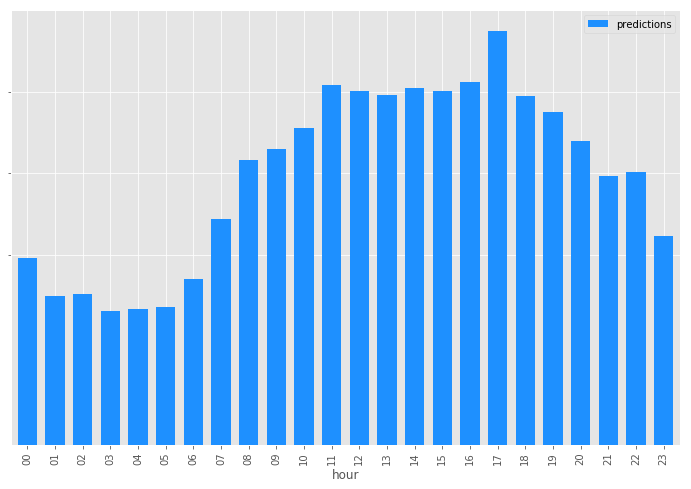

In [230]:
department = '93345'
# department = '79592'
day = 'Tuesday'

subset = test_df[(test_df['fire_department.firecares_id'] == department) 
                 & (test_df['description.day_of_week'] == day)]
subset = subset.sort_values(by='hour')
plt.rcParams['figure.figsize'] = [12,8]
subset.plot.bar(x='hour', y='predictions', color='dodgerblue', width=.7)
plt.yticks([0.7,1,1.3], [])

In [103]:
feature_list = ['fire_department.firecares_id_79592',
       'fire_department.firecares_id_93345', 'description.day_of_week_Friday',
       'description.day_of_week_Monday', 'description.day_of_week_Saturday',
       'description.day_of_week_Sunday', 'description.day_of_week_Thursday',
       'description.day_of_week_Tuesday', 'description.day_of_week_Wednesday',
       'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05',
       'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']  

In [87]:
hourly[['fire_department.firecares_id', 'description.day_of_week', 'hour', 'calls']].to_json('test', orient='records')

In [88]:
hourly

,fire_department.firecares_id,date,description.day_of_week,hour,calls,mean_calls,norm_calls
23429,79592,2018-09-24,Monday,09,5,6.908699,0.723725
47518,93345,2018-09-05,Wednesday,12,17,11.748610,1.446980
20196,79592,2018-04-05,Thursday,01,5,6.908699,0.723725
6976,79592,2016-05-11,Wednesday,19,7,6.908699,1.013215
44807,93345,2018-05-11,Friday,19,2,11.748610,0.170233
...,...,...,...,...,...,...,...
16243,79592,2017-09-11,Monday,01,23,6.908699,3.329136
42235,93345,2018-01-20,Saturday,11,15,11.748610,1.276747
20935,79592,2018-05-13,Sunday,16,4,6.908699,0.578980
1743,79592,2015-08-08,Saturday,20,11,6.908699,1.592195


,fire_department.firecares_id,date,description.day_of_week,hour,calls,mean_calls,norm_calls
12500,79592,2017-02-25,Saturday,14,2,6.908699,0.289490
7493,79592,2016-06-08,Wednesday,19,15,6.908699,2.171176
43353,93345,2018-03-09,Friday,13,15,11.748610,1.276747
26607,79592,2019-03-08,Friday,07,5,6.908699,0.723725
36576,93345,2017-05-21,Sunday,11,12,11.748610,1.021397
...,...,...,...,...,...,...,...
1465,79592,2015-07-24,Friday,15,4,6.908699,0.578980
5211,79592,2016-02-10,Wednesday,14,4,6.908699,0.578980
4312,79592,2015-12-26,Saturday,03,4,6.908699,0.578980
10386,79592,2016-11-09,Wednesday,21,8,6.908699,1.157960


In [74]:
hourly['hour'].unique()

array(['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '00', '03', '04', '07', '08', '09', '22', '23', '06', '01',
       '02', '05'], dtype=object)

In [75]:
fdid_list

array(['79592', '93345'], dtype=object)

In [80]:
hourly


,fire_department.firecares_id,date,description.day_of_week,hour,calls,mean_calls,norm_calls
0,79592,2015-05-05,Tuesday,10,18,6.908699,2.605411
1,79592,2015-05-05,Tuesday,11,11,6.908699,1.592195
2,79592,2015-05-05,Tuesday,12,10,6.908699,1.447450
3,79592,2015-05-05,Tuesday,13,11,6.908699,1.592195
4,79592,2015-05-05,Tuesday,14,6,6.908699,0.868470
...,...,...,...,...,...,...,...
58068,93345,2019-12-05,Thursday,05,2,11.748610,0.170233
58069,93345,2019-12-05,Thursday,06,5,11.748610,0.425582
58070,93345,2019-12-05,Thursday,07,10,11.748610,0.851164
58071,93345,2019-12-05,Thursday,08,17,11.748610,1.446980


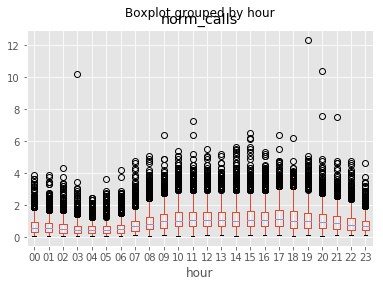

In [79]:
hourly.boxplot('norm_calls', by='hour')

In [30]:
# Hourly aggregation
hourly = df.drop(['description.event_opened','NFPA.type','weather'],axis=1).groupby(['date', 
                                                                'hour',
                                                                'fire_department.firecares_id'])

In [26]:
#Need average calls for each department for each department

,date,hour,fire_department.firecares_id,temperatureHigh,precipIntensity
0,2016-05-31,22,93345,84.004286,0.000000
1,2016-10-26,22,93345,61.018462,0.000000
2,2016-10-27,22,93345,69.756538,0.001411
3,2016-10-28,22,93345,64.516796,0.000000
4,2016-10-29,22,93345,75.396895,0.000001
...,...,...,...,...,...
1132,2019-12-01,22,93345,50.927547,0.015975
1133,2019-12-02,22,93345,49.032110,0.004459
1134,2019-12-03,22,93345,51.590464,0.000193
1135,2019-12-04,22,93345,52.676278,0.000226


In [13]:
#Getting the list of all departments in the dataframe
fdid_list = df['fire_department.firecares_id'].unique()


# Day aggregation
daily = df.drop(['description.event_opened','NFPA.type'],axis=1).groupby(['date', 
                                                                'description.day_of_week',
                                                                'fire_department.firecares_id']).aggregate(np.mean).reset_index()
def myagg(x):
    d = {
        'ems_calls': np.sum(x['NFPA.type'] == 'EMS'),
        'fire_calls': np.sum(x['NFPA.type'] == 'FIRE'),
        'other_calls': np.sum(x['NFPA.type'] == 'OTHER'),
        'precipType': x.iloc[0]['precipType'],
        'holiday': x.iloc[0]['holiday']
    }
    return pd.Series(d,index=d.keys())


calls = df[['date','NFPA.type','fire_department.firecares_id','precipType', 'holiday']].groupby(['date','fire_department.firecares_id']).apply(myagg).reset_index()
daily = daily.merge(calls,on=['date','fire_department.firecares_id'])

#Appending the mean and standard deviation to the daily dataframe
mean = daily[['fire_department.firecares_id','fire_calls','ems_calls','other_calls']].groupby(['fire_department.firecares_id']).aggregate(np.mean).reset_index()
mean = mean.rename(columns={'fire_calls': 'mean_fire', 'ems_calls': 'mean_ems', 'other_calls': 'mean_other'})

std = daily[['fire_department.firecares_id','fire_calls','ems_calls','other_calls']].groupby(['fire_department.firecares_id']).aggregate(np.std).reset_index()
std = std.rename(columns={'fire_calls': 'std_fire', 'ems_calls': 'std_ems', 'other_calls': 'std_other' })
daily = daily.merge(mean,on=['fire_department.firecares_id']).merge(std,on=['fire_department.firecares_id'])

daily['zfire'] = (daily['fire_calls'] - daily['mean_fire'])/daily['std_fire']
daily['zems'] = (daily['ems_calls'] - daily['mean_ems'])/daily['std_ems']
daily['zother'] = (daily['other_calls'] - daily['mean_other'])/daily['std_other']

#In a few places the day of the week is wrong. This line prevents that issue from causing bugs
daily = daily.drop_duplicates(['fire_department.firecares_id', 'date']).reset_index(drop=True)

#Dropping outliers
daily = daily[np.abs(daily['zems']) < 2.0].reset_index(drop=True)

#Then recalculating quantities
daily = daily.drop(['mean_fire','std_fire', 'mean_ems', 'std_ems', 'mean_other', 'std_other'],axis=1)
mean = daily[['fire_department.firecares_id','fire_calls','ems_calls','other_calls']].groupby(['fire_department.firecares_id']).aggregate(np.mean).reset_index()
mean = mean.rename(columns={'fire_calls': 'mean_fire', 'ems_calls': 'mean_ems', 'other_calls': 'mean_other'})

std = daily[['fire_department.firecares_id','fire_calls','ems_calls','other_calls']].groupby(['fire_department.firecares_id']).aggregate(np.std).reset_index()
std = std.rename(columns={'fire_calls': 'std_fire', 'ems_calls': 'std_ems', 'other_calls': 'std_other' })
daily = daily.merge(mean,on=['fire_department.firecares_id']).merge(std,on=['fire_department.firecares_id'])

daily['zfire'] = (daily['fire_calls'] - daily['mean_fire'])/daily['std_fire']
daily['zems'] = (daily['ems_calls'] - daily['mean_ems'])/daily['std_ems']
daily['zother'] = (daily['other_calls'] - daily['mean_other'])/daily['std_other']

daily['precipAccumulation'] = daily['precipAccumulation'].fillna(0)
daily['precipIntensity'] = daily['precipAccumulation'].fillna(0)
daily['precipType'] = daily['precipType'].fillna('None')

#Adding month as a feature
daily['month'] = daily['date'].apply(lambda x: str(x.month))

KeyError: 'precipAccumulation'

In [2]:
df = pd.read_json('./data/query_results.json')

Once we have the data locally, we can use use the tools provided by the SageMaker Python SDK to upload the data to a default bucket. 

In [3]:
WORK_DIRECTORY = 'data'
train_input = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

## Create SageMaker Scikit Estimator <a class="anchor" id="create_sklearn_estimator"></a>

To run our Scikit-learn training script on SageMaker, we construct a `sagemaker.sklearn.estimator.sklearn` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

To see the code for the SKLearn Estimator, see here: https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn

In [4]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'ems_call_prediction.py'

sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'n_estimators': 1000})

## Train SKLearn Estimator on EMS data <a class="anchor" id="train_sklearn"></a>
Training is very simple, just call `fit` on the Estimator! This will start a SageMaker Training job that will download the data for us, invoke our scikit-learn code (in the provided script file), and save any model artifacts that the script creates.

In [5]:
sklearn.fit({'train': train_input})

Creating tmp7294zq7f_algo-1-x7ddc_1 ... 
Attaching to tmp7294zq7f_algo-1-x7ddc_12mdone
algo-1-x7ddc_1  | 2020-01-09 20:19:43,580 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
algo-1-x7ddc_1  | 2020-01-09 20:19:43,585 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-x7ddc_1  | 2020-01-09 20:19:43,603 sagemaker_sklearn_container.training INFO     Invoking user training script.
algo-1-x7ddc_1  | 2020-01-09 20:19:43,902 sagemaker-containers INFO     Module ems_call_prediction does not provide a setup.py. 
algo-1-x7ddc_1  | Generating setup.py
algo-1-x7ddc_1  | 2020-01-09 20:19:43,903 sagemaker-containers INFO     Generating setup.cfg
algo-1-x7ddc_1  | 2020-01-09 20:19:43,903 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-x7ddc_1  | 2020-01-09 20:19:43,903 sagemaker-containers INFO     Installing module with the following command:
algo-1-x7ddc_1  | /usr/bin/python3 -m pip install . 
algo-1-x7ddc_1  | Pro

===== Job Complete =====


## Using the trained model to make inference requests <a class="anchor" id="inference"></a>

### Deploy the model <a class="anchor" id="deploy"></a>

Deploying the model to SageMaker hosting just requires a `deploy` call on the fitted model. This call takes an instance count and instance type.

In [ ]:
predictor = sklearn.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

### Choose some data and use it for a prediction <a class="anchor" id="prediction_request"></a>

In order to do some predictions, we'll extract some of the data we used for training and do predictions against it. This is, of course, bad statistical practice, but a good way to see how the mechanism works.

In [ ]:
import os
import pandas as pd
import json
from sklearn.ensemble import RandomForestRegressor
from pandas.io.json import json_normalize
from dateutil.relativedelta import SU
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import Holiday
import datetime
from sklearn.externals import joblib
import numpy as np

dataloc = './prediction_data/test_data.json'
with open(dataloc) as data_file:
    data = json.load(data_file)
features = pd.io.json.json_normalize(data['prediction_data'])


#Converting df dates to datetime objects for holiday merging
features['date'] = features.apply(lambda x: datetime.datetime.strptime(x['date'],'%Y-%m-%d'),axis=1)

#We can create new rules with this class inheritance
class custom_calendar(AbstractHolidayCalendar):
    new_rules = [
        Holiday('Halloween', month=10,day=31),
        Holiday('Christmas Eve', month=12,day=24),
        Holiday('New Years Eve', month=12,day=31),
        Holiday('DST time change', month=3, day=1, offset=pd.DateOffset(weekday=SU(2)))
    ]
    rules = calendar().rules + new_rules

cal = custom_calendar()
start = np.min(features['date'])
end = np.max(features['date'])
holidays = cal.holidays(start=start,end=end,return_name=True).reset_index()
holidays = holidays.rename(columns={'index':'date', 0:'holiday'})

#But really we want the Monday after the time change
holidays['date'] = holidays.apply(lambda x: x['date'] + datetime.timedelta(days=1) 
               if x['holiday'] == 'DST time change' else x['date'], axis=1)

features = features.merge(holidays, on='date', how='left')
features['holiday'] = features['holiday'].fillna('none')
#Filling missing values with the average
features['high_temp'] = features['high_temp'].fillna(np.mean(features['high_temp']))

#No longer need the date since we have all the information we need (day of week and month)
features = features.drop('date',axis=1)
#Using one hot encoding for categorical variables. Ask me if you want me to explain this further.
features = pd.get_dummies(features)

#Splitting the data into features (predictors) and labels (the quantity we want to predict)
labels = features['ems_calls']
features = features.drop('ems_calls',axis=1)

Prediction is as easy as calling predict with the predictor we got back from deploy and the data we want to do predictions with. The output from the endpoint return an numerical representation of the classification prediction; in the original dataset, these are flower names, but in this example the labels are numerical. We can compare against the original label that we parsed.

In [ ]:
print(predictor.predict(features.values))

### Endpoint cleanup <a class="anchor" id="endpoint_cleanup"></a>

When you're done with the endpoint, you'll want to clean it up.

In [ ]:
sklearn.delete_endpoint()

## Batch Transform <a class="anchor" id="batch_transform"></a>
We can also use the trained model for asynchronous batch inference on S3 data using SageMaker Batch Transform.

In [7]:
# Define a SKLearn Transformer from the trained SKLearn Estimator
transformer = sklearn.transformer(instance_count=1, instance_type='ml.m4.xlarge')

### Prepare Input Data <a class="anchor" id="prepare_input_data"></a>
We will extract 10 random samples of 100 rows from the training data, then split the features (X) from the labels (Y). Then upload the input data to a given location in S3.

In [8]:
#Upload test data to s3
WORK_DIRECTORY = 'prediction_data'
batch_input_s3 = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

### Run Transform Job <a class="anchor" id="run_transform_job"></a>
Using the Transformer, run a transform job on the S3 input data.

In [9]:
# Start a transform job and wait for it to finish
transformer.transform(batch_input_s3, content_type='application/json')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()

Waiting for transform job: sagemaker-scikit-learn-2019-10-03-16-54-00-785
..................Processing /opt/ml/code
  Created wheel for ems-call-prediction: filename=ems_call_prediction-1.0.0-py2.py3-none-any.whl size=4932 sha256=da6007a06a48f17f4e7e5df2d689a325893003d2745ce572e099e3f44b42aebf
  Stored in directory: /tmp/pip-ephem-wheel-cache-i4ajwoa7/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built ems-call-prediction
[2019-10-03 16:56:52 +0000] [37] [INFO] Starting gunicorn 19.9.0
[2019-10-03 16:56:52 +0000] [37] [INFO] Listening at: unix:/tmp/gunicorn.sock (37)
[2019-10-03 16:56:52 +0000] [37] [INFO] Using worker: gevent
[2019-10-03 16:56:52 +0000] [40] [INFO] Booting worker with pid: 40
[2019-10-03 16:56:52 +0000] [41] [INFO] Booting worker with pid: 41
[2019-10-03 16:56:52 +0000] [45] [INFO] Booting worker with pid: 45
[2019-10-03 16:56:52 +0000] [46] [INFO] Booting worker with pid: 46
2019-10-03 16:57:05,377 INFO - sagemaker-containers - No GP

### Check Output Data  <a class="anchor" id="check_output_data"></a>
After the transform job has completed, download the output data from S3. For each file "f" in the input data, we have a corresponding file "f.out" containing the predicted labels from each input row. We can compare the predicted labels to the true labels saved earlier.

In [10]:
# Download the output data from S3 to local filesystem
batch_output = transformer.output_path
!mkdir -p batch_data/output
!aws s3 cp --recursive $batch_output/ batch_data/output/
# Head to see what the batch output looks like
!head batch_data/output/*

download: s3://sagemaker-us-east-2-445861113736/sagemaker-scikit-learn-2019-10-03-16-54-00-785/test_data.json.out to batch_data/output/test_data.json.out
[14.262, 13.651, 13.776, 64.899, 32.359, 80.751, 119.24432222222221, 67.791, 14.291, 9.6, 77.111, 11.977, 71.26, 17.555, 76.62, 71.955, 65.988, 69.633, 72.4, 67.801, 16.868, 15.341, 14.491, 68.154, 73.672, 13.88, 11.946, 94.801953968254, 30.46, 76.214, 12.099, 32.963, 111.37256608946599, 75.409, 13.584, 10.49, 13.494, 14.924, 20.175, 13.632, 11.323, 79.148, 13.037, 13.741, 71.156, 12.984, 13.376, 71.529, 13.335, 14.749, 63.824, 73.622, 13.242, 10.425, 14.079, 70.725, 35.103, 14.916, 68.318, 16.027, 13.933, 13.86, 15.153, 61.511, 12.992, 69.234, 69.987, 13.4, 65.712, 11.144, 73.905, 63.855, 78.564, 69.216, 10.006, 12.519, 34.603, 65.763, 78.152, 13.837, 87.715, 13.497, 69.304, 68.77, 13.061, 69.625, 11.177, 9.125, 73.762, 69.42, 68.098, 70.547, 66.93, 16.691, 69.59, 16.193, 12.927, 73.688, 65.495, 72.673, 74.601, 66.103, 78.257, 14.602

In [73]:
# Pulling the predictions, comparing to the observed number of calls

Text(0, 0.5, 'actual')

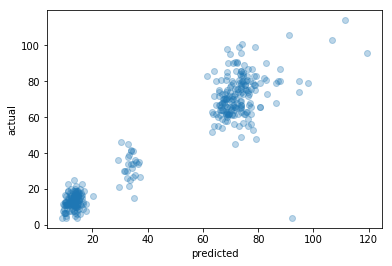

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
output_loc = './batch_data/output/test_data.json.out'

with open (output_loc, "r") as myfile:
    data=myfile.readlines()
    
string_output = data[0].replace('[','').replace(']','')

predicted = np.genfromtxt(StringIO(string_output),delimiter=',')
actual = np.genfromtxt('observed',delimiter=',')[1:,1]
plt.scatter(predicted,actual,alpha=0.3)
plt.xlabel('predicted')
plt.ylabel('actual')